In [77]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import sys
%run read_matlab_file.ipynb
%run convert_erg.ipynb
%run safety_time.ipynb
#matplotlib.use('TkAgg')
#sys.path.insert(0, '/Home/siv30/wad005/useful_py_functions') #UiB
sys.path.insert(0, "/Users/andreas/proggis/useful_py_func/") #Mac
import matplotlib_custom_style_and_macros as pltmacro #Importing the py file from dir 
#%run "/Users/andreas/proggis/useful_py_func/matplotlib_custom_style_and_macros.py" #excplicitly running the py file that sets the rcParams

read_matlab_file.ipynb loaded
read_matlab_file.ipynb loaded
convert_erg.ipynb loaded
read_matlab_file.ipynb loaded
read_matlab_file.ipynb loaded
convert_erg.ipynb loaded


# TODO

    -Problem: importing the plot_HED function. Tried to return fig, ax objects, but they are not showing

    -Problem: Fucked up the pltmacro. Might be caused by the "TkAgg" backend.
    Solution: The pltmacro file is imported correctly but when one is generating plots from another notebook the rcParams in TkAgg backend kicks in.
    
    -When one is creating final plots, it should be done in the current notebook

    -Rebin the data based on given energy interval, subtract background in the given energy interval.

    -Implement in this script the previous functions that implement: absolute time correction, energy calibration, flagging of events

    -Should have the dataset that have implemented the functions above
    
    
    
    
    - Make a df that describes the data and how it have been processed GRB190206,HED, NOT LED, ENERGY intervall present, bg on interval
    
    -hist count, 

# Notes

    - be careful of using is True or is not True. There are two types of booleans: np.bool_ or native python bool
    USE: == or !=
    
    - a lot of energies are converted to keV = 351.4519739

# complete df

In [9]:
def complete_df(grb_id):
    if len(trig_dict_HED[grb_id])>1:
        return print("long grb, handle later")
    else:
        tus, erg, typ, adr, dau, det, T0 = read_matlab_file_with_BGO_data(trig_dict_HED[grb_id][0])
        keV,cal_abc = convert_erg(erg, dau, det, T0)
        print("erg converted to keV")
        df = create_df(tus,erg,typ,adr,dau,det,keV,cal_abc)
        df = df.sort_values(by=['adr','tus']) #important to sort first by the adr then tus --> Handling the triggers in each detector seperate
        print("df sorted by adr and tus")
        #Creating columns for st, dt and flag
        st_list = get_st(df)
        df["st"] = st_list
        
        dt_list = get_dt(df)
        df["dt"] = dt_list
        
        flag = get_flag(df) #should also flag fast events!
        df["flag"] = flag
        
        print("safety time events flagged. " + "Found " + str(sum(df["flag"].to_numpy())) + " flags")
        return df,T0

In [81]:
df,T0 = complete_df("GRB190206")
print(df.shape)
df.head()

Absolute time correction subtracted from tus array and T0
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 287 flags
(24587, 11)


,tus,erg,typ,adr,dau,det,keV,cal_abc,st,dt,flag
16,-491943.976667,299,0,1,1,1,2998.481096,"0.004946, 8.3696, 53.79335",12.993924,NaN,False
17,-491803.948889,1815,0,1,1,1,31537.854200,"0.004946, 8.3696, 53.79335",25.615142,140.027778,False
19,-491737.948889,260,0,1,1,1,2564.238950,"0.004946, 8.3696, 53.79335",11.256956,66.000000,False
54,-488456.782222,1057,0,1,1,1,14426.374104,"0.004946, 8.3696, 53.79335",21.000000,3281.166667,False
84,-485219.698889,37,0,1,1,1,370.239624,"0.004946, 8.3696, 53.79335",0.000000,3237.083333,False


# filtering energy interval

In [146]:
# df is soreted by adr and then tus

def filter_by_energy_interval(df,lower_bound,upper_bound):
    """lower and upper bound given in keV"""
    
    tus_arr = df["tus"].to_numpy()
    kev_arr = df["keV"].to_numpy()
    flag_arr = df["flag"].to_numpy()
    
    
    tus_temp, kev_temp = [],[]
    print("selecting kev interval. Not including flagged events")
    for i,kev in enumerate(kev_arr):
        if lower_bound <= kev <= upper_bound and flag_arr[i] != True:
            kev_temp.append(kev)
            tus_temp.append(tus_arr[i])
        else:
            continue

    return np.array(tus_temp), np.array(kev_temp)
    

# background estimation

In [111]:
def estimate_background(tus,start=None,end=None,binsize=None):
    """Estimates background on a given interval.
    Using histograms for estimation. 
    -Constant fit: sum(bin counts)/length(bins)
    -Binsize given in ms
    -indexing of the bins hist[start_idx, end_idx) >> up to but not including the end_idx bin
    """
 
   
    ####### histogram binning
    
    #Problem: how many bins should be included when one specifies an end time of the interval?
    #Solution: find_nearest(edgde_bg,
    
    if binsize == None:
        return print("binsize need to be specified")
    
    hist = np.histogram(tus/1e3,bins=np.arange(
            min(tus/1e3), max(tus/1e3) + binsize, binsize)) #binning in ms not us
    
    hist_bg = hist[0]
    edges = hist[1] #array of position the hist bin start
    
    if start=="start" or start==None:
        start_idx = 0
    else:
        start_idx = find_nearest(edges,start)
        
    if end == None:
        return print("end index need to be specified")
    else:
        end_idx = find_nearest(edges,end)
        bg = round(sum(hist_bg[start_idx:end_idx])/len(hist_bg[start_idx:end_idx]))
        print("bg avg:", bg)
        #bg = 220
        hist_bg -= bg #subtracting background all bins.
        
    return hist[0], hist_bg, edges, bg

# generate plots

In [166]:
def plots(grb_id=None, lower_bound=None, upper_bound=None, start=None, end=None, binsize=10):
    '''Need plots for original image, filtered energy range with background marked, filtered with background removed
    
    Improvement. Just call the grb_id and binsize! 

    '''
    
    df,T0 = complete_df(grb_id)
    tus = df["tus"].to_numpy()
    tus_filt, kev_filt = filter_by_energy_interval(df,lower_bound,upper_bound)
    hist,hist_bg,edges,bg = estimate_background(tus_filt,start=start,end=end,binsize=binsize)
    
    
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True,figsize=(16,6))
    
    ax1.hist(tus/1e3, bins=np.arange(
            min(tus/1e3), max(tus/1e3) + binsize, binsize),edgecolor="black",histtype="step",label="photon list LC")
    
    ax2.hist(tus_filt/1e3,bins=np.arange(
        min(tus_filt/1e3), max(tus_filt/1e3) + binsize, binsize),edgecolor= "black", histtype="step",label="Energy range {}-{} keV".format(round(min(kev_filt)),
                                                                                                                             round(max(kev_filt))))
    ax2.axhline(bg,c="r",label="Background: {} counts/bin \n Background interval [{},{}] ms".format(bg,start,end))
    
    ax3.bar(edges[:-1], hist_bg ,width=np.diff(edges), edgecolor="black", align="edge",color="black",label="Background subtracted. \n Energy range {}-{} keV".format(round(min(kev_filt)),
                                                                                                                             round(max(kev_filt)))) #np.diff gives the diff pr bin (constant=binsize)

    ax1.legend(), ax2.legend(), ax3.legend()
    ax1.set_xlabel("T-T0 [ms], binsize = {} ms".format((binsize))),ax2.set_xlabel("T-T0 [ms], binsize = {} ms".format((binsize)))
    ax3.set_xlabel("T-T0 [ms], binsize = {} ms".format((binsize)))
    
    
    date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: GRBYYMMDD
    time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12]
    grb_id_title = "GRB " + date_id
    plt.suptitle(grb_id_title + " , " + "T0 = " + time_id)
    
    plt.show()
    

Absolute time correction subtracted from tus array and T0
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 187 flags
selecting kev interval. Not including flagged events
bg avg: 6


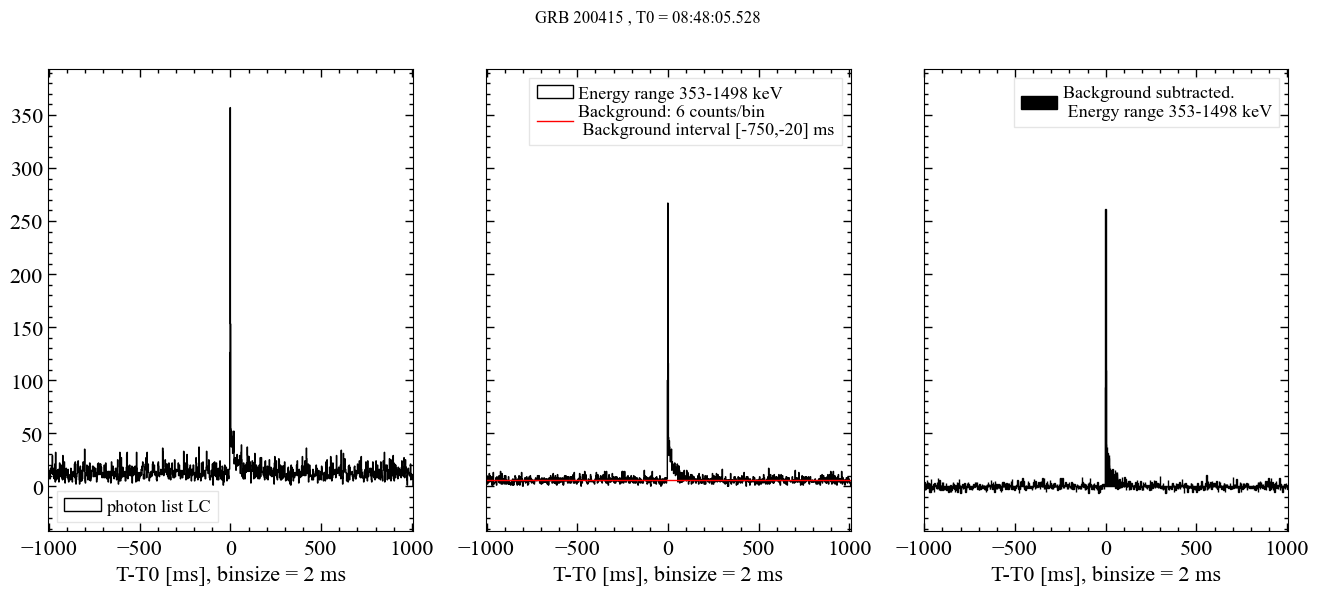

In [167]:
plots(grb_id="GRB200415",lower_bound=350,upper_bound=1500,start=-750,end=-20,binsize=2)

In [ ]:
def plot_flagged(grb_id,binsize):
    df,T0 = complete_df(grb_id)
    
    tus_flagged = get_flagged()
    
    

In [169]:
df,T0 = complete_df("GRB200415")
sum(df["flag"].to_numpy())

Absolute time correction subtracted from tus array and T0
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 187 flags


187

In [170]:
df.shape

(14494, 11)

In [173]:
14610-14494-187 #should be 71 valleys and overflow events

-71